# Выявление закономерностей, определяющих успешность компьютерных игр

## 1. Функции

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from urllib.parse import urlencode

In [4]:
LINK_DATA = "https://yadi.sk/d/1i5qk87U31kPmg"

In [5]:
def get_year_nan_info(df, group):
    """
    Получение таблицы, где для каждой игры для года релиза указано
    количество пропусков и количество значений без пропусков
    """
    column = 'year_of_release'
    x = df[df[column].isna()].groupby(group)[group].count()
    y = df[~(df[column].isna())].groupby(group)[group].count()

    year_nan = pd.DataFrame({'year_of_release_nan': x}).reset_index()
    year_not_nan = pd.DataFrame({'year_of_release_not_nan': y}).reset_index()
    year_data = year_nan.merge(year_not_nan, on=group, how='left')
    
    for gr in year_data[group].values:
        values = df[(df[group] == gr) 
                       & (~(df[column].isna()))][column].unique()
        num = len(values)
        year_data.loc[year_data[group] == gr,'year'] = str(values).strip('\[\]')
        year_data.loc[year_data[group] == gr,'num_values'] = int(num)
    
    return year_data

In [6]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [7]:
def check_df_nan(data):
    """
    Функция получает количество пропусков в процентном соотношении (и типы 
    данных для каждого столбца с пропусками)
    """
    df_length = data.shape[0]
    null_stat = {}

    for col in data.columns:
        col_nan = data[data[col].isnull()].shape[0]
        pct = col_nan / df_length * 100

        if pct > 0:
            null_stat[col] = [round(pct, 3), data[col].dtype]
    
    info = (pd.DataFrame
     .from_dict(null_stat, orient='index', columns=['percentage', 'data_type'])
     .sort_values(by='percentage', ascending=False)
    )
    
    return info

In [8]:
def custom_fillna(row):
    """
    Заполнение пропусков для года релиза (берем самую часто встречаемую дату)
    """
    name = row['name']
    year = str(row['year_of_release']).lower()
    # самая большая частота даты релиза для игры
    count = year_statistic[(year_statistic.name == name)]['count'].max()
    
    if year == "nan" and str(count) != 'nan':
        # самая часто встречаемая дата релиза для игры
        year_value = year_statistic[(year_statistic.name == name) &
                                    (year_statistic['count'] == count)
                                   ]['year_of_release'].values[0]
        row['year_of_release'] = year_value
            
    return row

In [9]:
def median_score(df, column, row):
    """
    Заполнение пропусков в оценках
    """
    median = df[(df.genre == row.genre)][column]['median'].values[0]
    return median

In [10]:
def fillna_critic_score(row):
    """
    Заполнение пропусков в оценках (критиков)
    """
    column = 'critic_score'
    if str(row[column]).lower() == 'nan':
        row[column] = median_score(critic_score_stat, column, row)
    return row

In [11]:
def fillna_user_score(row):
    """
    Заполнение пропусков в оценках
    """
    column = 'user_score'
    if str(row[column]).lower() == 'nan':
        row[column] = median_score(user_score_stat, column, row)
    return row

In [12]:
def get_figure(df, x, y, legend='', width=12, height=8, fig=None, ax=None,
               xlocator=5, ylocator=100, xlabel='', ylabel='', kind='line',
               label_loc='upper right', show=True, trick=True, xticks=False):
        
    if not (fig and ax):
        fig, ax = plt.subplots()
    
    df.plot(x=x, y=y, ax=ax, kind=kind)
    
    if trick:
        # интервал основных и вспомогательных делений
        ax.xaxis.set_major_locator(ticker.MultipleLocator(xlocator))
        #ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(ylocator))
        #ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

        # линии основной сетки
        ax.grid(which='major', color = 'k', linewidth = 0.3)

        # видимость вспомогательных делений
        ax.minorticks_on()

        # внешний вид вспомогательной сетки
        ax.grid(which='minor',
                color = 'grey',
                linestyle = ':'
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend([legend], loc=label_loc)
    # размеры графика
    fig.set_figwidth(width)
    fig.set_figheight(height)
    
    if xticks:
        plt.xticks(xticks, rotation=45, horizontalalignment='right');
    if show:
        plt.show()

In [13]:
def get_subplots(dframe, goal_name, goals_list, kind='line',
                 xlabel='', ylabel='', x=None, y=None, 
                 rows=1, cols=3, figsize=(15,20)):
    # сичтаем количество необходимых строк в пуле графиков
    nrows = len(goals_list) % cols + len(goals_list) // cols
    fig, axs = plt.subplots(nrows=nrows, ncols=cols)
    # счетчик для последующего обхода списка goals
    cnt = len(goals_list) - 1
    for i in range(nrows): 
        for j in range(cols):
            ax = axs[i][j]
            try:
                goal = goals_list.pop(cnt)
            except IndexError:
                break
            cnt -= 1
            df = dframe[dframe[goal_name] == goal]
            # получаем атомарный график по кастомной функции
            get_figure(df, fig=fig, ax=ax, kind=kind, x=x, y=y, 
                       legend=goal, xlabel=xlabel, ylabel=ylabel,
                       width=15, height=20, show=False, trick=False
                      )
    fig.tight_layout()
    plt.show()

In [14]:
def get_boxplot_plaforms(df, x, y, loc='lower right', size=(15,8)):
    """
    Функция для построения диаграммы размаха
    """
    fig, ax = plt.subplots(figsize=size)
    sns.boxplot(y=y, x=x, orient='h',
                     data=df, 
                     palette="colorblind",
                     hue=y, ax=ax)

    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    plt.legend(loc=loc)
    plt.show()

In [15]:
def get_true_range(s, k=1.5):
    """
    Получение границ дтапазона [-k*iqr, +k*iqr]
    """
    iqr = st.iqr(s)
    quantile = s.quantile([.25, .75])
    first = round(quantile[0.25] - k * iqr, 2)
    third = round(quantile[0.75] + k * iqr, 2)
    return (first, third)

In [16]:
def drop_values(df, group, param):
    """
    Удаление выбросов
    """
    groups = list(df[group].unique())
    for gr in groups:
        series = df[df[group] == gr][param]
        true_range = get_true_range(series)        
        df.drop(df[(df[group] == gr)
                   & ((df[param] < true_range[0]) 
                      | (df[param] > true_range[1]))].index,
                axis=0,
                inplace=True
               )
    return df

In [17]:
def corr_visual(corr_df):
    """
    Визуализация матрицы корреляции
    """
    return sns.heatmap(corr_df, linewidths=.5, cmap="coolwarm", annot=True)

In [18]:
def get_scatter(df):
    """
    Диаграмма рассеяния для продаж и оценок
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    df.plot.scatter(x='user_score', y='sales', c='c', ax=ax1)
    df.plot.scatter(x='critic_score', y='sales', c='c', ax=ax2)
    plt.show()

In [19]:
def get_region_stat(main_df, gen_df, param, group='platform'):
    part_param = 'sales'
    df = (main_df.groupby(group)[param].sum().to_frame().reset_index())
    df = df.merge(gen_df, on=group, how='left')
    df['part'] = (df[param] / df[part_param]).round(2)
    df = df.sort_values(by='part', ascending=False)    
    return df

In [20]:
def check_null_hypothesis(sample_1, sample_2, alpha=0.05, norm=True):
    """
    Функция проверки нулевой гипотезы
    """
    if norm:
        results = st.ttest_ind(sample_1, sample_2)
    else:
        results = st.mannwhitneyu(sample_1, sample_2)
        
    print('p-value:', results.pvalue)

    if results.pvalue < alpha:
        print('Отклоняем нулевую гипотезу')
    else:
        print('Не удалось отклонить нулевую гипотезу')

In [21]:
sns.set(rc={'figure.figsize':(15,6)})

## 2. Загрузка данных

In [22]:
games_data = pd.read_csv(get_url(LINK_DATA))
games_data.sample(5)

Run https://yadi.sk/d/1i5qk87U31kPmg


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
12996,Sled Shred featuring the Jamaican Bobsled Team,Wii,2010.0,Sports,0.05,0.00,0.00,0.00,NaN,tbd,E
71,Donkey Kong Country,SNES,1994.0,Platform,4.36,1.71,3.00,0.23,NaN,NaN,NaN
16205,Tobidase! Kagaku-kun Chikyuu Daitanken! Nazo n...,DS,2011.0,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
8362,Terminator 3: The Redemption,PS2,2004.0,Shooter,0.08,0.06,0.00,0.02,68.0,8,T
13668,Puyo Pop Fever,PSP,2004.0,Puzzle,0.00,0.00,0.04,0.00,68.0,NaN,NaN


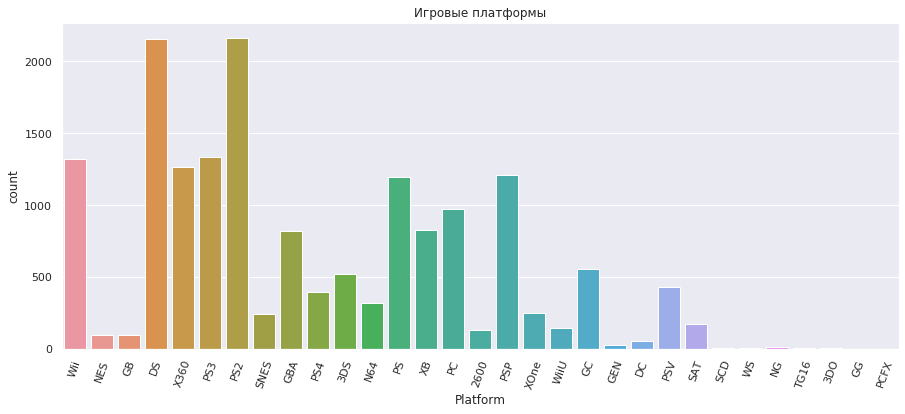

In [23]:
g = sns.countplot(data=games_data, x='Platform');
plt.xticks(rotation=70);
plt.title('Игровые платформы');

In [24]:
# приведем к одному виду в нижнем регистре
games_data.columns = games_data.columns.str.lower()
games_data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [25]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [26]:
check_df_nan(games_data)

,percentage,data_type
critic_score,51.319,float64
rating,40.479,object
user_score,40.090,object
year_of_release,1.609,float64
name,0.012,object
genre,0.012,object


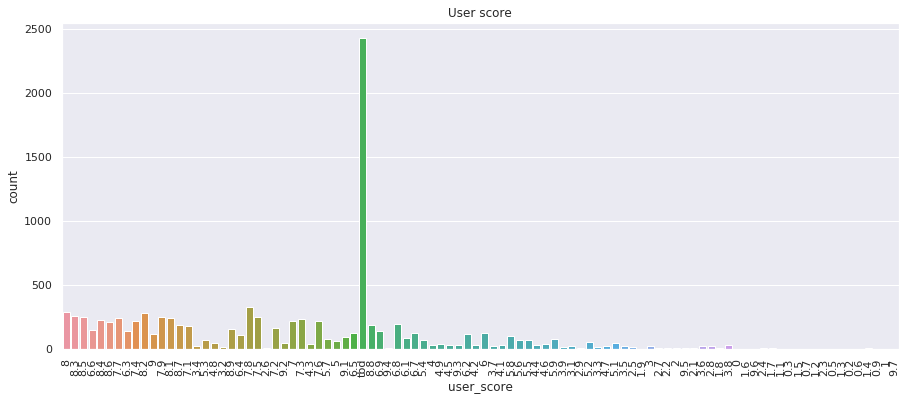

In [27]:
g = sns.countplot(data=games_data, x='user_score');
plt.xticks(rotation=90);
plt.title('User score');

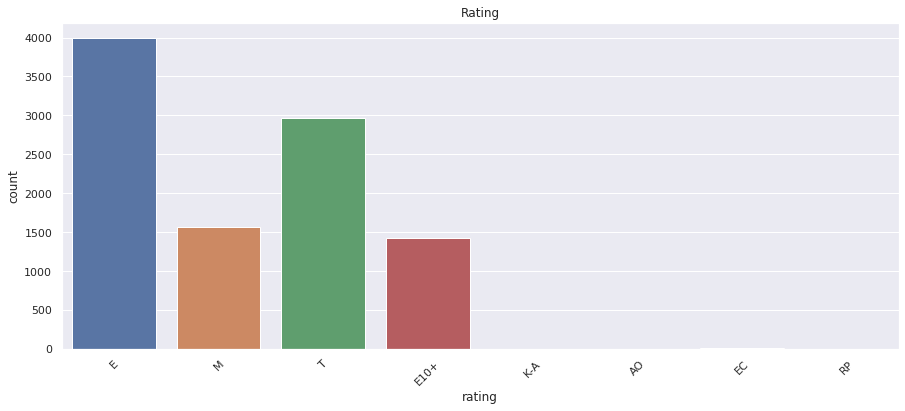

In [28]:
g = sns.countplot(data=games_data, x='rating');
plt.xticks(rotation=45);
plt.title('Rating');

### Вывод

* В данных присутствуют строковые и цисловые значения.
* В 5 столбцах присутствуют пропуски, больше всего - для данных с оценками и рейтингом: _critic_score, rating, user_score._
* В столбце с оценками пользователей _user_score_ помимо числовых данных значений присутствует _"tbd"_ - [термин](https://en.wikipedia.org/wiki/To_be_announced), который означает, что значение будет утверждено позднее.
* В столбце оценки [ESRB](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board) (Entertainment Software Rating Board) указаны категории рейтинга:
    * __E__ ("Everyone") — Для всех;
    * __T__ ("Teen") — Подросткам;
    * __M__ ("Mature") — Для взрослых;
    * __EC__ ("Early childhood") — Для детей младшего возраста;
    * __RP__ ("Rating Pending") — Рейтинг ожидается;
    * __AO__ ("Adults Only 18+") — Только для взрослых;
    * __K-A__  ("Kids to Adults") — первоначальное название категории "E";
    * __E10+__ ("Everyone 10 and older") — Для всех от 10 лет и старше.
    

## 3. Подготовка данных

### Согласованность строковых данных

Приведем данные названия игры, платформы и жанра к нижнему регистру.

In [29]:
for column in ['name', 'platform', 'genre']:
    games_data[column] = games_data[column].str.lower().str.strip()

In [30]:
games_data.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11148,the mummy: tomb of the dragon emperor,ds,2008.0,action,0.08,0.00,0.00,0.01,43.0,tbd,T
10688,nba 2k16,pc,2015.0,sports,0.03,0.06,0.00,0.01,NaN,5.7,E10+
5825,shrek swamp kart speedway,gba,2002.0,racing,0.22,0.08,0.00,0.01,27.0,8.9,E
13213,sd gundam: over galaxian,ps,1996.0,shooter,0.00,0.00,0.05,0.00,NaN,NaN,NaN
4038,scarface: the world is yours,xb,2006.0,action,0.37,0.11,0.00,0.02,76.0,8.4,M


### Обработка пропусков

Посмотрим на количество пропусков в имени и жанре игр.

In [31]:
games_data[(games_data.name.isna()) | (games_data.genre.isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В полученных строках пропуски в таких данных, как оценка критиков, пользователей и рейтинг. Такие наблюдения не пригодятся в поставленной задаче, удалим их.

In [32]:
games_data = games_data.drop(games_data[(games_data.name.isna()) 
                                        | (games_data.genre.isna())].index)

Посмотрим на количество пропусков в значениях о дате релиза.

In [33]:
games_data[games_data.year_of_release.isna()].shape[0]

269

Посмотрим на пропуски в данных для каждой игры.

In [34]:
# получим данные, где нет пропусков в дате релиза
year_data = games_data[~(games_data.year_of_release.isna())][[
    'name','platform','year_of_release']]

# сгруппируем по платформе и имени игры (значение все равно одно, так что 
# берем max() как агрегирующую функцию)
year_statistic = (year_data
                  .groupby(['name','platform'])['year_of_release']
                  .max()
                  .to_frame()
                  .reset_index()
                 )
year_frequency = (year_statistic
                  .groupby(['name', 'year_of_release'])
                  .agg({"year_of_release": "count"})
                  .rename(columns={"year_of_release": "count"})
                  .reset_index()
                 )

year_statistic = year_statistic.merge(
    year_frequency,
    on=['name', 'year_of_release'], how='left')

year_statistic.sort_values(by='name').sample(10)

,name,platform,year_of_release,count
6878,kingdom: ikkitousen no ken,psp,2010.0,1
2692,darksiders ii,xone,2015.0,2
14439,the walking dead: season two,ps3,2014.0,5
7760,mario & sonic at the rio 2016 olympic games,3ds,2016.0,2
7558,madden nfl 15,ps3,2014.0,4
9755,nobunaga no yabou: souzou,ps3,2013.0,1
12756,spider-man: shattered dimensions,ds,2010.0,4
14051,the italian job,xb,2003.0,3
13605,tank beat,ds,2006.0,1
5423,gundam breaker 3,ps4,2016.0,2


In [35]:
check_df_nan(games_data)

,percentage,data_type
critic_score,51.313,float64
rating,40.471,object
user_score,40.083,object
year_of_release,1.610,float64


In [36]:
games_data = games_data.apply(custom_fillna, axis=1)
check_df_nan(games_data)

,percentage,data_type
critic_score,51.313,float64
rating,40.471,object
user_score,40.083,object
year_of_release,0.874,float64


Осталось мало пропусков для года релиза (0.87%), удалим такие записи.

In [37]:
games_data = games_data.drop(games_data[games_data.year_of_release.isna()].index)

# оставшиеся пропуски
check_df_nan(games_data)               

,percentage,data_type
critic_score,51.259,float64
rating,40.436,object
user_score,40.037,object


In [38]:
# посмотрим на данные без оценок вообще
null_score = games_data[(games_data.rating.isna()) &
           (games_data.user_score.isna()) &
           (games_data.critic_score.isna())
          ]
null_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6555 entries, 1 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             6555 non-null   object 
 1   platform         6555 non-null   object 
 2   year_of_release  6555 non-null   float64
 3   genre            6555 non-null   object 
 4   na_sales         6555 non-null   float64
 5   eu_sales         6555 non-null   float64
 6   jp_sales         6555 non-null   float64
 7   other_sales      6555 non-null   float64
 8   critic_score     0 non-null      float64
 9   user_score       0 non-null      object 
 10  rating           0 non-null      object 
dtypes: float64(6), object(5)
memory usage: 614.5+ KB


In [39]:
# посмотрим на платформы с пропусками в рейтинге и без
all_platform = len(games_data.platform.unique())
null_platform = len(null_score.platform.unique())
print('''
Всего платформ:        {}
Платформ с пропусками: {}
'''.format(all_platform, null_platform))


Всего платформ:        31
Платформ с пропусками: 31



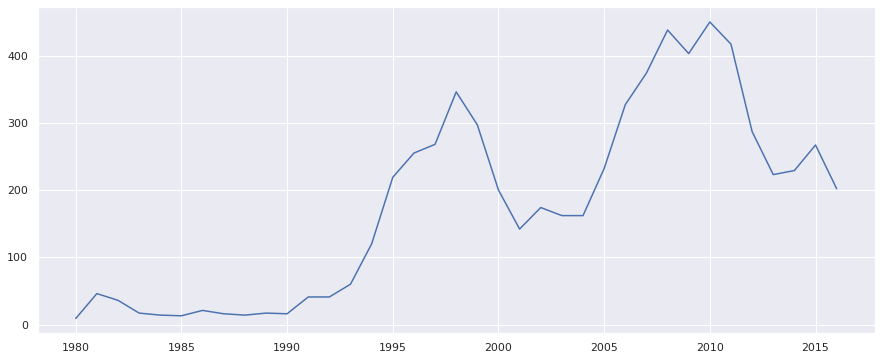

In [40]:
# посмотрим на даты релиза с пропусками в рейтинге и без
null_score.year_of_release.value_counts().sort_index().plot();

Видим, что 40% данных без оценок вообще и от платформы не зависят. Ни от года релиза, ни от платформы пропуски не зависят. Согласно правилам ESRB в онлайн-играх, содержимое которых может модифицироваться пользователями, используется замечание _"Game Experience May Change During Online Play"_, которое предупреждает о том, что контент не проходил рецензирования ESRB. Возможно, данные об онлайн-играх выкачивались из других источников, поэтому столько пропусков и в других столбцах с оценкой. Заменим пустые значения на "NO_DATA".

In [41]:
games_data['rating'].fillna( "NO_DATA", inplace=True)

check_df_nan(games_data)

,percentage,data_type
critic_score,51.259,float64
user_score,40.037,object


In [42]:
# сколько данных с оценкой пользователя = tbd
games_data[games_data.user_score == 'tbd'].shape

(2394, 11)

In [43]:
# создадим таблицу, где нет пропусков в оценках критиков
critic_score = games_data[~(games_data.critic_score.isna())]

# сгруппируем по жанрам и посмотрим на медиану и среднее
critic_score_stat = (
    critic_score
    .groupby(['genre'])
    .agg({'critic_score':['median', 'mean'],
}).reset_index()
)

critic_score_stat

genre critic_score           
                       median       mean
0         action         68.0  66.658147
1      adventure         66.0  65.271028
2       fighting         72.0  69.250000
3           misc         69.0  66.560078
4       platform         69.0  68.073320
5         puzzle         70.0  67.354260
6         racing         69.0  68.032653
7   role-playing         74.0  72.672131
8        shooter         73.0  70.284492
9     simulation         70.0  68.595989
10        sports         75.0  71.999158
11      strategy         73.0  72.040134

In [44]:
# заполним данные для оценки критика медианой
games_data = games_data.apply(fillna_critic_score, axis=1)

In [45]:
# проверка значений
games_data.critic_score.value_counts().sort_index().tail(5)

94.0    37
95.0    16
96.0    18
97.0    11
98.0     4
Name: critic_score, dtype: int64

In [46]:
check_df_nan(games_data)

,percentage,data_type
user_score,40.037,object


In [47]:
# создадим таблицу, где нет пропусков в оценках пользователей
user_score = games_data[~(games_data.user_score.isna()) &
                        (games_data.user_score != 'tbd')
                       ]
user_score['user_score'] = user_score['user_score'].astype('float')
# сгруппируем по жанрам и посмотрим на медиану и среднее
user_score_stat = (
    user_score
    .groupby(['genre'])
    .agg({'user_score':['median', 'mean'],
}).reset_index()
)

user_score_stat

genre user_score          
                     median      mean
0         action        7.4  7.056484
1      adventure        7.6  7.139597
2       fighting        7.6  7.299497
3           misc        7.1  6.809677
4       platform        7.7  7.298353
5         puzzle        7.5  7.156693
6         racing        7.4  7.039874
7   role-playing        7.8  7.623442
8        shooter        7.4  7.045802
9     simulation        7.5  7.127353
10        sports        7.4  6.956375
11      strategy        7.8  7.299026

In [48]:
# заполним данные для оценки пользователей медианой
games_data = games_data.apply(fillna_user_score, axis=1)

Заполним пропуски в _critic_score_ и _user_score_ медианой, так как в данном случае эта характеристика более устойчива к выбросам.

In [49]:
check_df_nan(games_data).shape

(0, 2)

In [50]:
games_data.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1325,nba 2k14,ps4,2013.0,sports,0.89,0.31,0.01,0.23,85.0,6.5,E
1136,tony hawk's american wasteland (old all region...,ps2,2005.0,sports,0.80,0.63,0.01,0.19,75.0,7.4,NO_DATA
11838,margot's word brain,ds,2008.0,puzzle,0.07,0.00,0.00,0.01,70.0,tbd,E10+
10141,call of juarez: the cartel,pc,2011.0,shooter,0.05,0.05,0.00,0.01,51.0,3.3,M
13452,gummy bears mini golf,ds,2010.0,sports,0.04,0.00,0.00,0.00,75.0,7.4,NO_DATA


Доля данных со значением tdb - 14.5%. Это значение осмысленно нечем заменить, так как это может сильно исказить выводы поставленной задаче. Создадим отдельную таблицу с данными без этого значения.

In [51]:
games = games_data[games_data.user_score != "tbd"]
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14173 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14173 non-null  object 
 1   platform         14173 non-null  object 
 2   year_of_release  14173 non-null  float64
 3   genre            14173 non-null  object 
 4   na_sales         14173 non-null  float64
 5   eu_sales         14173 non-null  float64
 6   jp_sales         14173 non-null  float64
 7   other_sales      14173 non-null  float64
 8   critic_score     14173 non-null  float64
 9   user_score       14173 non-null  object 
 10  rating           14173 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.3+ MB


Возможные причины пропусков - сбор данных из нескольких источников и как результат, пропуски при объединении таблиц с данными.

### Преобразование типов данных

In [52]:
games['user_score'] = games['user_score'].astype('float')

# указан только год, поэтому проще будет работать с целыми числами
games['year_of_release'] = games['year_of_release'].astype('int')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14173 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14173 non-null  object 
 1   platform         14173 non-null  object 
 2   year_of_release  14173 non-null  int64  
 3   genre            14173 non-null  object 
 4   na_sales         14173 non-null  float64
 5   eu_sales         14173 non-null  float64
 6   jp_sales         14173 non-null  float64
 7   other_sales      14173 non-null  float64
 8   critic_score     14173 non-null  float64
 9   user_score       14173 non-null  float64
 10  rating           14173 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.3+ MB


### Поиск дубликатов

In [53]:
games[games.duplicated()].shape[0]

0

Дубликатов нет.

### Насыщение данных

In [54]:
# Подсчет суммарных продаж во всех регионах и запишите их в отдельный столбец
games['sales'] = games['na_sales'] + games['eu_sales'] + \
    games['jp_sales'] + games['other_sales']
games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
11248,the sims 2: apartment life,pc,2008,simulation,0.00,0.07,0.00,0.01,75.0,7.7,T,0.08
63,mario kart 64,n64,1996,racing,5.55,1.94,2.23,0.15,69.0,7.4,NO_DATA,9.87
2560,professor layton vs phoenix wright: ace attorney,3ds,2012,puzzle,0.20,0.26,0.30,0.04,79.0,8.5,T,0.80
15851,divinity: original sin,pc,2014,role-playing,0.00,0.02,0.00,0.00,87.0,8.7,M,0.02
11633,diego's build & rescue,ds,2010,action,0.07,0.00,0.00,0.01,68.0,7.4,NO_DATA,0.08


### Вывод

* Строковые данные приведены к согласованному виду
* Пропуски заполнены
* Ошибок и дубликатов не обнаружено
* Преобразование типов данных выполнено
* Данные без пропусков выделены в отдельную талице _games_
* Добавлен столбец с общим объемом продаж

##  4. Исследовательский анализ данных

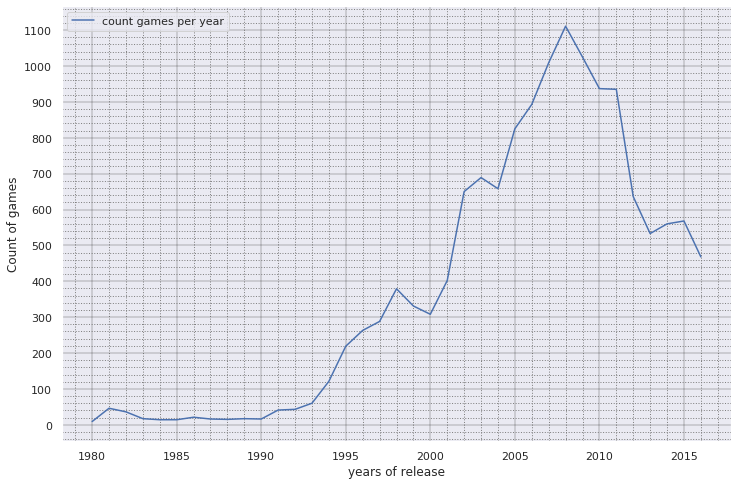

In [55]:
# сколько игр выпускалось в разные годы
games_year_all = games.groupby('year_of_release')['name'].count().to_frame().reset_index()

get_figure(games_year_all, x='year_of_release', y='name', width=12, height=8, 
           legend='count games per year', label_loc='upper left',
           xlabel='years of release', ylabel='Count of games')

Полученный график демонстрирует динамику появления игр на протяжении 1980-20016 гг (одна игра под разные платформы считается как несколько игр). Приведенный период можно разделить на три фазы:
1. 1980-1990 гг. - игровая индустрия почти не развивалась.
2. 1990-2008 гг. - продолжительная фаза развития с небольшими колебаниями. В этот период произошло значительное развитие технологий, таких как:
    * устройства храния данных;
    * развитие архитектуры процессоров и усовершенствование технологий для них;
    * переход к трехмерной графике и распространение 3D-графических процессоров;
    * развитие ПО (в частности операционные системы);
    * развитие Интернет-технологий.
3. 2008-2009 гг. - мировой финансовый кризис. 2008-20016 гг. - фаза спада развития комьютерных игр с небольшими колебаниями. В это время стемительно начало развиваться направление мобильных платформ, и многие компании направили часть деятельности в разработку мобильных игр, получив положительный отклик от пользователей и тем самым уменьшив темпы развития компьтерных игр.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


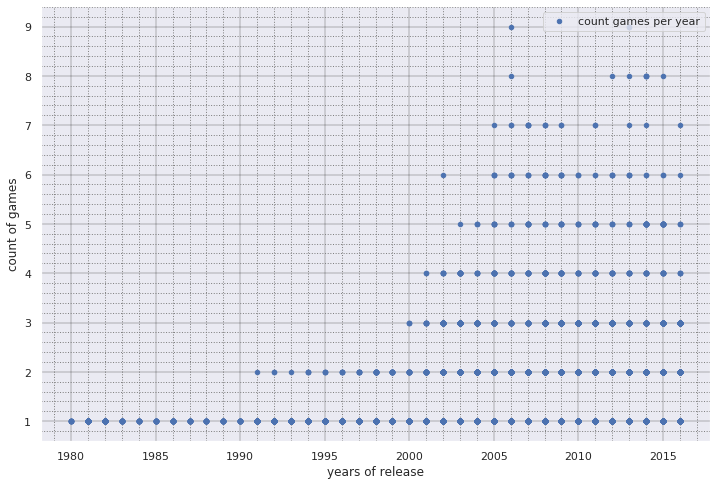

In [56]:
games_year = (games
              .groupby(['name', 'year_of_release'])['name']
              .count()
              .to_frame()
              .rename(columns={'name':'count'})
              .reset_index()
              .sort_values(by='year_of_release')
             )

get_figure(games_year, x='year_of_release', y='count', 
           width=12, height=8, legend='count games per year', 
           xlabel='years of release', ylabel='count of games', 
           xlocator=5, ylocator=1, kind='scatter')

Учитывая число релизов игр по годам с учетом платформ и без учета, можно сделать вывод, что период 1980-1993 гг - не показателен для дальнейшего анализа.

In [57]:
platforms_sales = (games
                   .groupby(['platform', 'year_of_release'])['sales']
                   .sum().to_frame().reset_index())
platforms_sales.sample(10)

,platform,year_of_release,sales
28,ds,1985,0.02
33,ds,2008,102.49
171,psp,2013,3.38
152,ps3,2011,155.34
166,psp,2008,34.56
150,ps3,2009,128.92
70,gen,1993,0.65
238,xone,2013,18.96
81,nes,1983,10.96
189,snes,1991,16.22


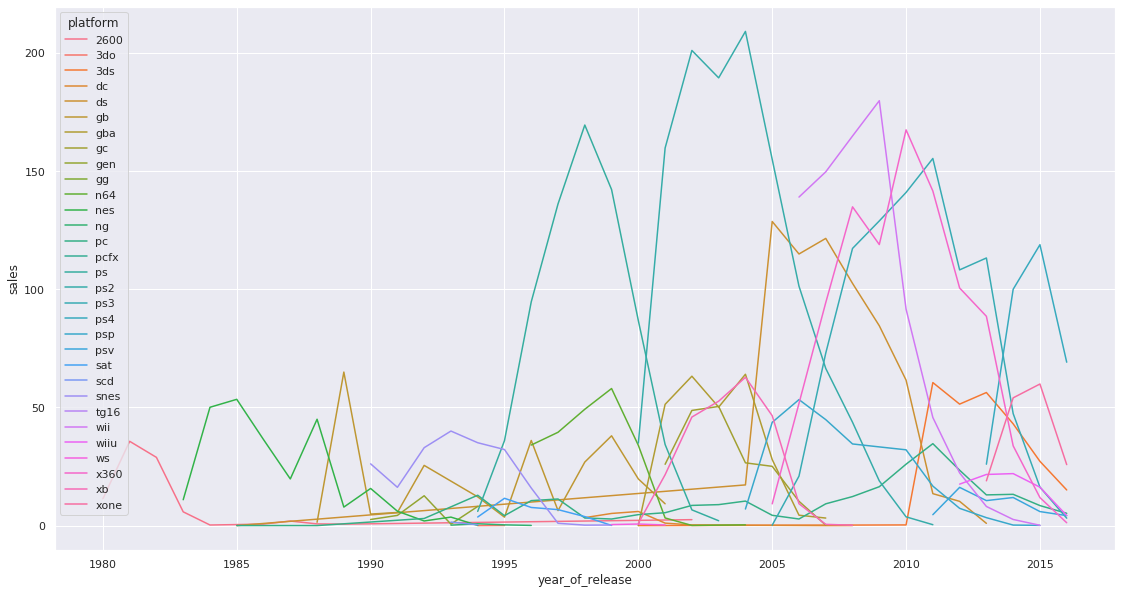

In [58]:
# посторим графики для каждой платформы: динамика продаж по годам

platforms = platforms_sales.platform.value_counts().index.to_list()
# get_subplots(platforms_sales, 'platform', platforms, kind='line',
#              x='year_of_release', y='sales', xlabel='year of release', 
#              ylabel='sales')
_, ax = plt.subplots(1, figsize=(19,10))
sns.lineplot(x="year_of_release", y="sales", hue="platform", ax=ax,
             data=platforms_sales);

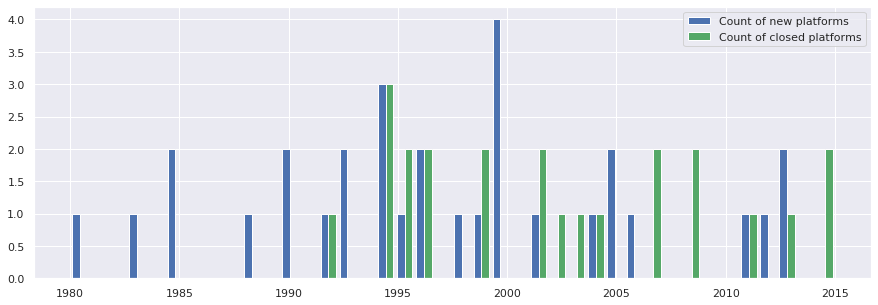

In [59]:
# посмотрим, за какой характерный срок появляются новые и исчезают старые платформы

plt.style.use('seaborn-deep')
plt.figure(figsize=(15,5))
x = platforms_sales.groupby('platform')['year_of_release'].min()
y = (platforms_sales
     .groupby('platform')['year_of_release']
     .max()
     .to_frame()
    )
y = y[y.year_of_release < 2016]['year_of_release']
plt.hist([x, y], bins=40, label=['Count of new platforms', 
                                 'Count of closed platforms'])
plt.legend(loc='upper right')
plt.show()

Из перечня графиков сделаны выводы:
* многие платформы перестали получать прибыть до 2000 года
* самая динамичная по прибыли платформа - _PS_
* в период 1992-1996 гг больше всего появляется и исчезает игровых платформ.

Определим период 1998-2016 гг. как актуальный, так как нужно период 1992-1996 гг с резкими колебаниями привнесет помехи в дальнейший прогноз.

Определим период 2011-2016 гг. как актуальный, так как этот период соответствует третьей фазе, которая наибольим образом соответствует началу 2017 года.

In [60]:
actual_games = games[(games.year_of_release > 2011)]
actual_games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
16,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,73.0,7.4,NO_DATA,14.63
33,pokemon x/pokemon y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,74.0,7.8,NO_DATA,14.60
34,call of duty: black ops ii,ps3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [61]:
# посмотрим на число продаж для каждой платформы за актуальный период
actual_games.platform.value_counts()

ps3     468
psv     404
ps4     386
3ds     368
x360    283
pc      250
xone    236
psp     172
wiiu    142
wii      38
ds       18
Name: platform, dtype: int64

Получили данные за актуальный период.

In [62]:
actual_games_group = (actual_games
                      .groupby('platform')['sales']
                      .sum()
                      .sort_values(ascending=False)
                      .to_frame()
                      .reset_index()
)

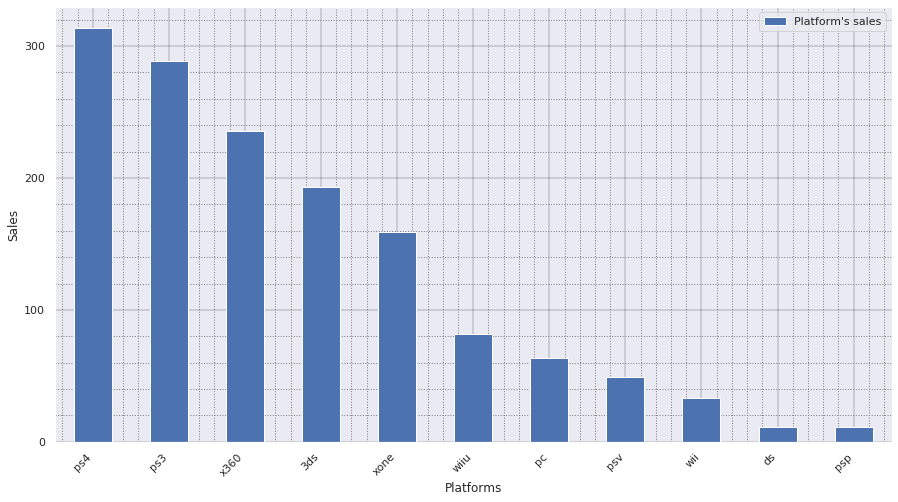

In [63]:
# распределение продаж по платформам

xticks=range(0,len(actual_games_group.platform))

get_figure(actual_games_group, x='platform', y='sales', kind='bar',
           legend="Platform's sales", width=15, height=8,
           xlocator=1, ylocator=100, xlabel='Platforms', ylabel='Sales',
           show=True, trick=True, xticks=xticks)

На диаграмме видно, что прибыльнее всего за актуальный период 5 платформ: _ps4, ps3, x360, 3ds, xone_. Это потенциально прибыльные платформы, выделим в отдельный датафрейм.


In [64]:
popular_platforms = actual_games[actual_games.platform.isin(['ps4', 'ps3', 'x360', '3ds', 'xone'])]

Для популярных платформ за актуальный период построим диаграмму размаха.

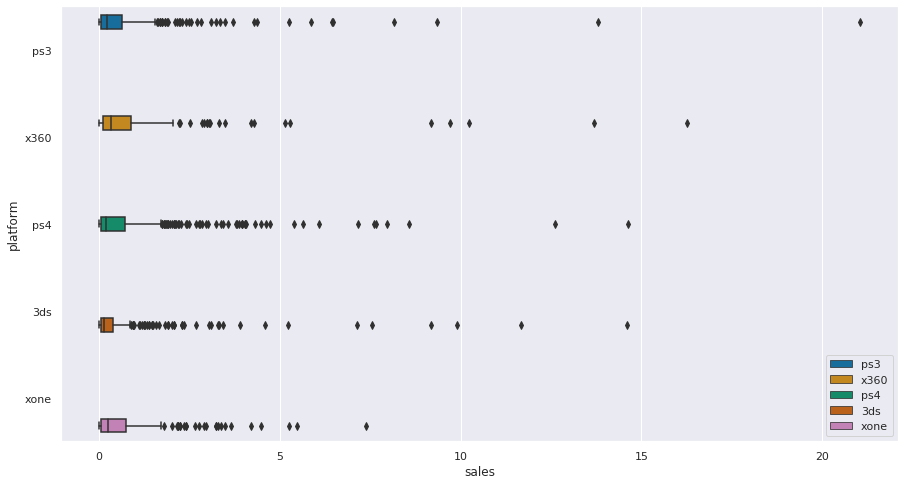

In [65]:
get_boxplot_plaforms(popular_platforms, x='sales', y='platform', loc='lower right')

Для платформ медианы примерно одинаковы, однако, много выбросов.

In [66]:
print(popular_platforms.shape)
popular_platforms = drop_values(popular_platforms, 'platform', 'sales')
print(popular_platforms.shape)

(1741, 12)
(1563, 12)


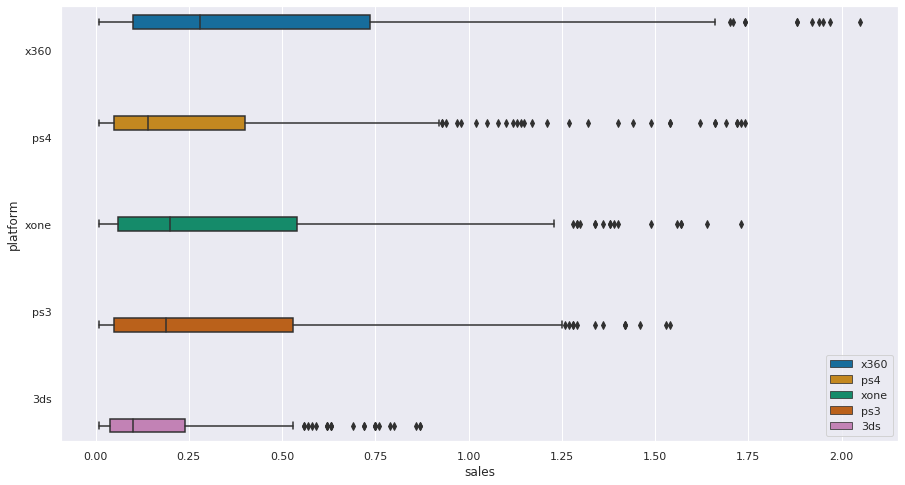

In [67]:
get_boxplot_plaforms(popular_platforms, x='sales', y='platform', loc='lower right')

После удаления выбросов видно, что платформа _x360_ - лидер продаж. Однако, в апреле 2016 года компания Microsoft объявила о прекращении производства игровых приставок Xbox 360, выпускавшихся с 2005 года. Поэтому для дальнейших предполжений на 2017 год платформа x360 учитываться не будет.

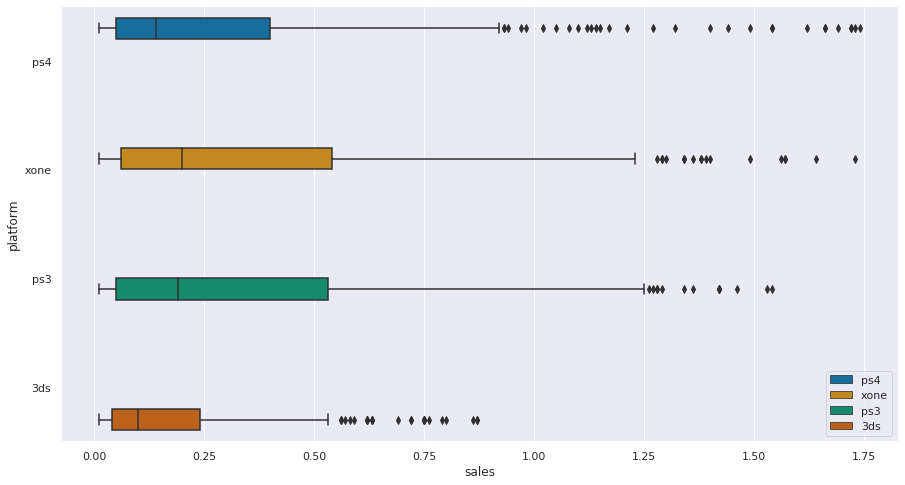

In [68]:
popular_platforms = popular_platforms[popular_platforms.platform != 'x360']
get_boxplot_plaforms(popular_platforms, x='sales', y='platform', loc='lower right')

Из полученных данных видно, что _xone_ - новый лидер продаж, а _ps3_ имеет близкую медиану. Меньшие, но близкие между собой медианы имеют платформы _ps4 и 3ds_.

Рассмотрим влияние отзывов пользователей и критиков на продажи на примере популярной платформы _xone_.

In [69]:
xone_data = popular_platforms[popular_platforms.platform == 'xone']
xone_data.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
12516,attack on titan (koei),xone,2016,action,0.02,0.03,0.0,0.00,68.0,7.4,NO_DATA,0.05
13413,xcom 2,xone,2016,strategy,0.02,0.02,0.0,0.00,87.0,8.1,T,0.04
8491,mirror's edge catalyst,xone,2016,platform,0.09,0.06,0.0,0.01,72.0,4.4,T,0.16
4117,nhl 16,xone,2015,sports,0.38,0.05,0.0,0.05,80.0,6.0,E10+,0.48
16188,darksiders: warmastered edition,xone,2016,action,0.01,0.00,0.0,0.00,80.0,7.9,M,0.01


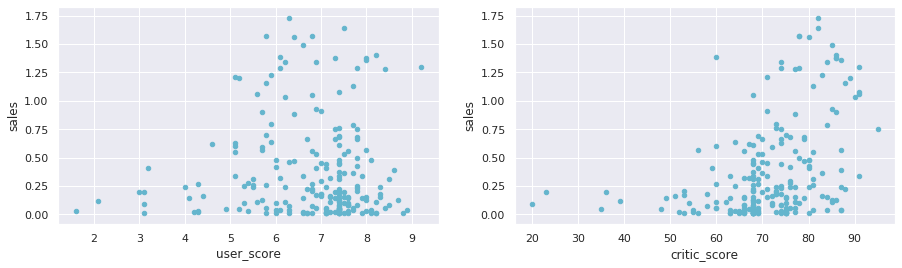

In [70]:
get_scatter(xone_data)

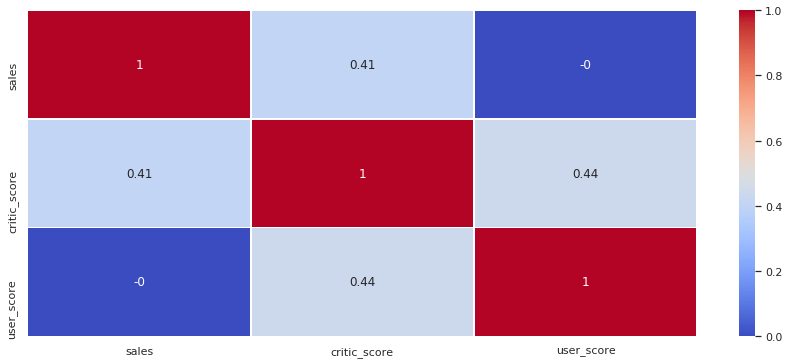

In [71]:
xone_data_corr = xone_data[['sales','critic_score','user_score']].corr().round(2)
corr_visual(xone_data_corr);

Матрица корреляции и диаграммы рассеяния демонстрируют следующие выводы:
* продажи не зависят от оценки пользователей
* между оценкой критиков и ростом продаж существует средняя зависимость

Посмотрим на зависимость продаж от оценок на других платформах.

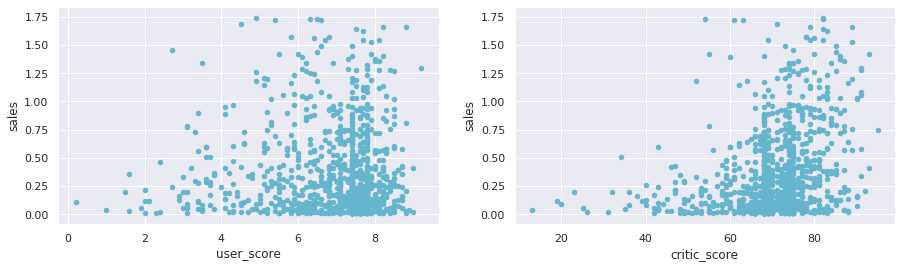

In [72]:
# диаграмма рассеяния
get_scatter(popular_platforms)

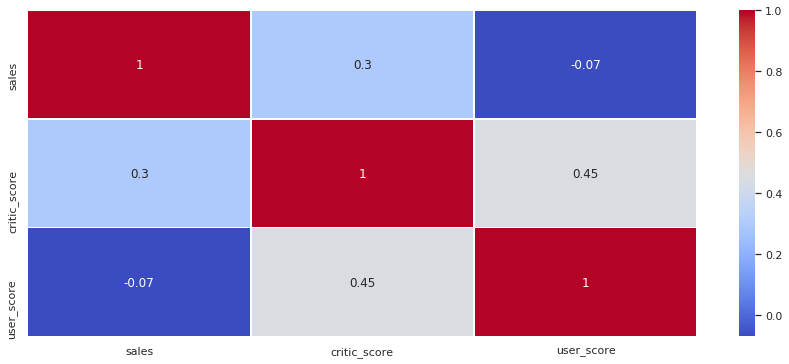

In [73]:
# матрица корреляции для всех популярных платформ
popular_platforms_corr = popular_platforms[[
    'sales','critic_score','user_score']].corr().round(2)
corr_visual(popular_platforms_corr)

Матрица корреляции и диаграммы рассеяния для всех популярных платформ в общей сложности демонстрируют следующие выводы:
* продажи почти не зависят от оценки пользователей
* между оценкой критиков и ростом продаж существует средняя зависимость, но меньше, чем на самой прибыльной платформе.

При соспостовлении отдельного результата для самой прибыльной платформы и для пяти самых прибыльных (популярных) платформ, можно сделать вывод, что параметром, который влияет на объем продаж, является _оценка критиков_.

Посмотрим на распределение продаж игр по жанрам за актуальный период.

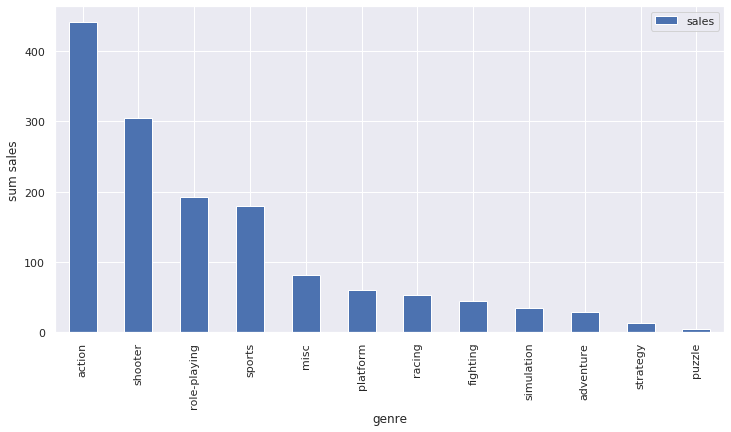

In [74]:
(actual_games
 .groupby('genre')['sales']
 .sum()
 .to_frame()
 .reset_index()
 .sort_values(by='sales', ascending=False)
 .plot(x='genre', y='sales', kind='bar', figsize=(12,6))
 .set_ylabel("sum sales")
);

Посмотрим на распределение медиан продаж игр по жанрам за актуальный период.

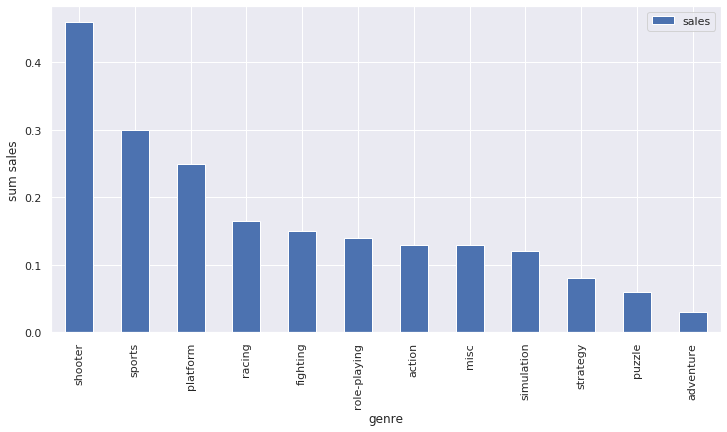

In [75]:
(actual_games
 .groupby('genre')['sales']
 .median()
 .to_frame()
 .reset_index()
 .sort_values(by='sales', ascending=False)
 .plot(x='genre', y='sales', kind='bar', figsize=(12,6))
 .set_ylabel("sum sales")
);

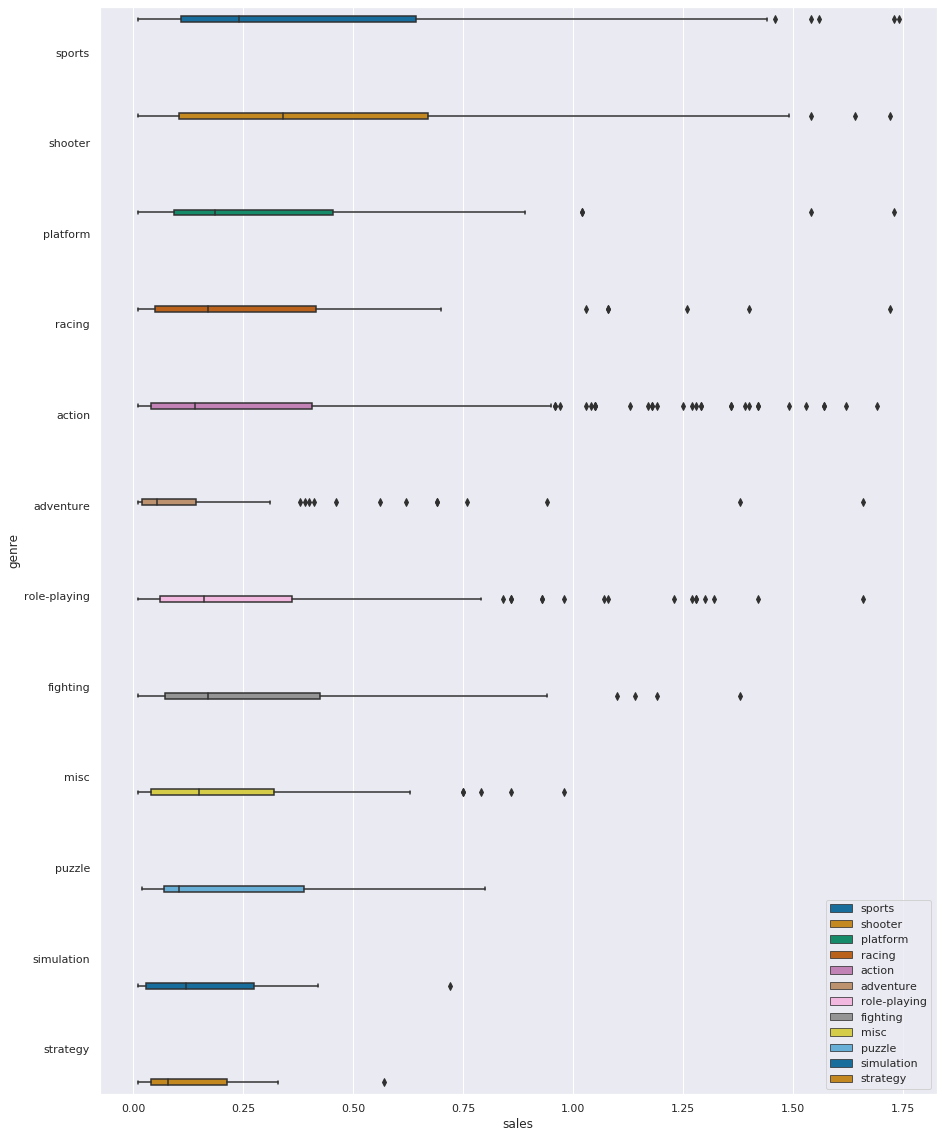

In [76]:
get_boxplot_plaforms(popular_platforms, x='sales', y='genre', 
                     loc='lower right',  size=(15,20))

Согласно  суммарным подсчетам, самый окупаемый жанр _action_. Однако, из диаграммы размаха видно, что данные этого жанра имеют много выбросов. Из диаграммы распределения медиан (так как много выбросов) продаж по жанрам, видны хорошо окупаемые жанры - _shooter, sports, platform_ , наименее окупаемые - _adventure, strategy, puzzle_. Остальные полаформы приносят примерно одинаковыю прибыль.

### Вывод

По __динамике продаж по годам__ для каждой платформы в отдельности сделаны выводы:
* многие платформы перестали получать прибыть до 2000 года
* самая динамичная по прибыли платформа - _PS_
* в период 1992-1996 гг больше всего появляется и исчезает игровых платформ.

Исследование показало:
* _актуальный_ период - 20011-2016 гг.;
* прибыльнее всего за актуальный период 5 платформ: _ps4, ps3, 3ds, xone_ - потенциально прибыльные платформы;
* плаформа _xone_ - самая прибыльная на момент исследуемого периода данных.

На примере самой прибыльной платформы _xone_ выяснено:
* продажи не зависят от оценки пользователей;
* между оценкой критиков и ростом продаж существует средняя зависимость.

На примере всех прибыльных платформ выяснено:
* продажи не зависят от оценки пользователей
* между оценкой критиков и ростом продаж существует средняя зависимость.

При соспостовлении отдельного результата для самой прибыльной платформы и для топ-3 самых прибыльных платформ, выяснено, что параметром, который влияет на объем продаж, является _оценка критиков_.

При исследовании жанров выяснено, что самый окупаемый жанр - _shooter_ , а в топ-5 хорошо окупаемых жанров также входят _shooter, sports, platform_ .

## 5. Портрет пользователя

### Определение данных

Для пользователя каждого региона (NA, EU, JP) определим самые популярные платформы (топ-5) по актуальным данным. Определение  будет осуществляться по продажам в целевом регионе.

In [77]:
# общая популярность платформ
platform_popularity = (actual_games.groupby('platform')['sales']
                       .sum().to_frame().reset_index())

platform_popularity.sample(5)

,platform,sales
2,pc,63.42
8,wiiu,81.79
3,ps3,288.31
10,xone,158.77
4,ps4,314.00


In [78]:
na_popularity = get_region_stat(actual_games, platform_popularity, 'na_sales')
na_popularity.head(5)

,platform,na_sales,sales,part
9,x360,139.68,235.98,0.59
10,xone,92.77,158.77,0.58
7,wii,16.75,33.18,0.50
8,wiiu,37.90,81.79,0.46
1,ds,4.35,11.25,0.39


In [79]:
eu_popularity = get_region_stat(actual_games, platform_popularity, 'eu_sales')
eu_popularity.head(5)

,platform,eu_sales,sales,part
2,pc,38.29,63.42,0.60
4,ps4,141.09,314.00,0.45
3,ps3,106.67,288.31,0.37
7,wii,10.63,33.18,0.32
9,x360,74.39,235.98,0.32


In [80]:
jp_popularity = get_region_stat(actual_games, platform_popularity, 'jp_sales')
jp_popularity.head(5)

,platform,jp_sales,sales,part
5,psp,10.53,11.06,0.95
0,3ds,87.68,193.11,0.45
6,psv,20.93,48.87,0.43
1,ds,3.72,11.25,0.33
8,wiiu,13.01,81.79,0.16


Для регионов NA, EU, JP выделены вледующие топ 5 популярных платформ:

* ___NA___:   _xb, gc, n64, x360, xone_
* ___EU___:   _pc, ps4, ps3, xone, ps_
* ___JP___:   _dc, psv, 3ds, gb, psp_

Для актуального периода определим топ-5 самых популярных жанров для каждого региона.

In [81]:
# общая популярность жанров
genre_popularity = (actual_games.groupby('genre')['sales']
                       .sum().to_frame().reset_index())

genre_popularity

,genre,sales
0,action,441.41
1,adventure,28.50
2,fighting,44.37
3,misc,82.24
4,platform,60.19
5,puzzle,4.69
6,racing,53.25
7,role-playing,192.80
8,shooter,304.46
9,simulation,34.56


In [82]:
na_genres = get_region_stat(actual_games, genre_popularity, 'na_sales', group='genre')
na_genres.head(5)

,genre,na_sales,sales,part
8,shooter,144.66,304.46,0.48
3,misc,36.90,82.24,0.45
10,sports,81.13,179.93,0.45
2,fighting,19.73,44.37,0.44
4,platform,25.15,60.19,0.42


In [83]:
eu_genres = get_region_stat(actual_games, genre_popularity, 'eu_sales', group='genre')
eu_genres.head(5)

,genre,eu_sales,sales,part
6,racing,27.19,53.25,0.51
9,simulation,14.31,34.56,0.41
11,strategy,5.17,13.34,0.39
10,sports,68.69,179.93,0.38
8,shooter,113.33,304.46,0.37


In [84]:
jp_genres = get_region_stat(actual_games, genre_popularity, 'jp_sales', group='genre')
jp_genres.head(5)

,genre,jp_sales,sales,part
5,puzzle,2.14,4.69,0.46
7,role-playing,65.44,192.80,0.34
9,simulation,10.35,34.56,0.30
1,adventure,8.24,28.50,0.29
11,strategy,2.88,13.34,0.22


Для регионов NA, EU, JP выделены вледующие топ 5 популярных жанров:

* ___NA___:   _shooter, fighting, platform, sports, action_
* ___EU___:   _racing, shooter, simulation, action, sports_
* ___JP___:   _role-playing, adventure, strategy, puzzle, fighting_

In [85]:
# отдельный фрейм для числовых значений рейтинга
category_list = ['NO_DATA', 'E', 'T', 'M', 'EC', 'RP', 'AO', 'K-A', 'E10+']
number_list = list(range(len(category_list)))

d = {'rating': category_list, 'rating_number': number_list}
rating_dict = pd.DataFrame(data=d)
rating_dict

,rating,rating_number
0,NO_DATA,0
1,E,1
2,T,2
3,M,3
4,EC,4
5,RP,5
6,AO,6
7,K-A,7
8,E10+,8


In [86]:
# добавим числовую расшифровку к actual_games
actual_games = actual_games.merge(rating_dict, on='rating', how='left')
actual_games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_number
2280,loading human,ps4,2016,adventure,0.01,0.01,0.00,0.00,66.0,7.6,NO_DATA,0.02,0
1369,murdered: soul suspect,ps3,2014,action,0.05,0.05,0.02,0.02,68.0,7.1,M,0.14,3
875,hatsune miku: project diva f 2nd,psv,2014,misc,0.08,0.05,0.16,0.04,81.0,8.4,T,0.33,2
2400,back to the future: the game,x360,2015,adventure,0.02,0.00,0.00,0.00,66.0,7.5,NO_DATA,0.02,0
1191,tom clancy's splinter cell: blacklist,pc,2013,action,0.04,0.13,0.00,0.01,82.0,7.4,M,0.18,3


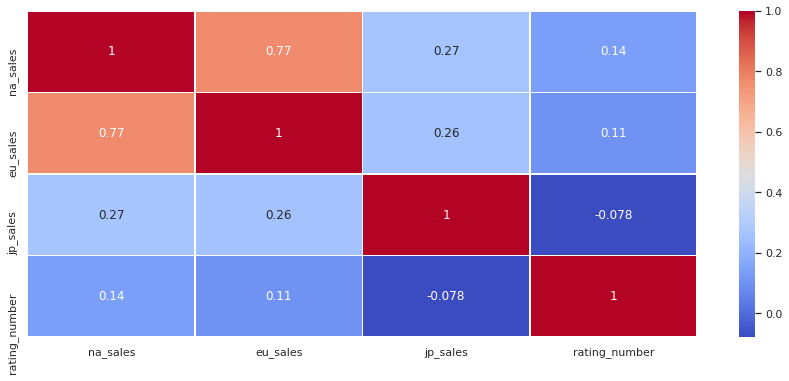

In [87]:
# матрица корреляции
regions_rating = actual_games[['na_sales', 'eu_sales', 'jp_sales', 'rating_number']]
regions_rating_corr = regions_rating.corr()
corr_visual(regions_rating_corr)

Из матрицы корреляции видно, что продажи в разных регионах очень слабо зависят от рейтинга организации _ESRB_.

### Вывод

Для регионов NA, EU, JP выделены вледующие топ 5 популярных платформ:
* ___NA___:   _xb, gc, n64, x360, xone_
* ___EU___:   _pc, ps4, ps3, xone, ps_
* ___JP___:   _dc, psv, 3ds, gb, psp_

Видно, что регион JP значительно отличается по выбору игровых платформ, а NA и EU схожи в выборе xone.

Для регионов NA, EU, JP выделены вледующие топ 5 популярных жанров:

* ___NA___:   _shooter, fighting, platform, sports, action_
* ___EU___:   _racing, shooter, simulation, action, sports_
* ___JP___:   _role-playing, adventure, strategy, puzzle, fighting_

Здесь также регион JP отличается по предпочтениям, а NA и EU выблирают action, sports, shooter.

Выяснено, что продажи в разных регионах очень слабо зависят от рейтинга организации _ESRB_.

## 6. Проверка гипотез

### Подготовка данных

In [88]:
# для выбранных платформ
xone_pc = actual_games[
    (actual_games.platform == 'xone') 
    | (actual_games.platform == 'pc')][['platform', 'user_score']]

In [89]:
# для выбранных жанров
action_sports = actual_games[(actual_games.genre == 'action') 
    | (actual_games.genre == 'sports')][['genre', 'user_score']]

### Гипотеза 1 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем _нулевую_ гипотезу: "Средние пользовательские рейтинги платформ Xbox One и PC равны". Тест будет осуществляться как сравнение двух средних, так как сравниваем две выборки по средним.

Сформулируем _альтернативную_ гипотезу: "Средние пользовательские рейтинги платформ Xbox One и PC отличаются".

In [90]:
xone = xone_pc[xone_pc.platform == 'xone' ]['user_score']
pc = xone_pc[xone_pc.platform == 'pc' ]['user_score']
print(xone.shape)
print(pc.shape)

(236,)
(250,)


In [91]:
print('Xone')
print(xone.apply([np.mean, np.var, np.std]))
print()
print('PC')
print(pc.apply([np.mean, np.var, np.std]))

Xone
mean    6.736441
var     1.631092
std     1.277142
Name: user_score, dtype: float64

PC
mean    6.609200
var     2.470076
std     1.571647
Name: user_score, dtype: float64


Посмотрим на распределение пользовательских отзывов для _xone_ и _pc_.

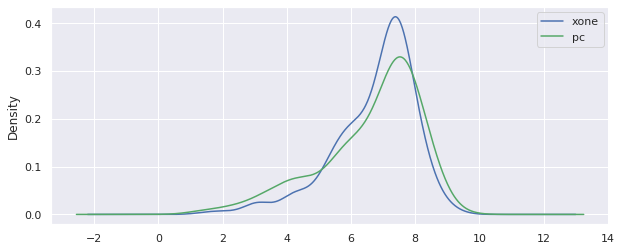

In [92]:
ax = xone.plot.kde(figsize=(10,4))
pc.plot.kde(ax=ax)
ax.legend(['xone', 'pc'])

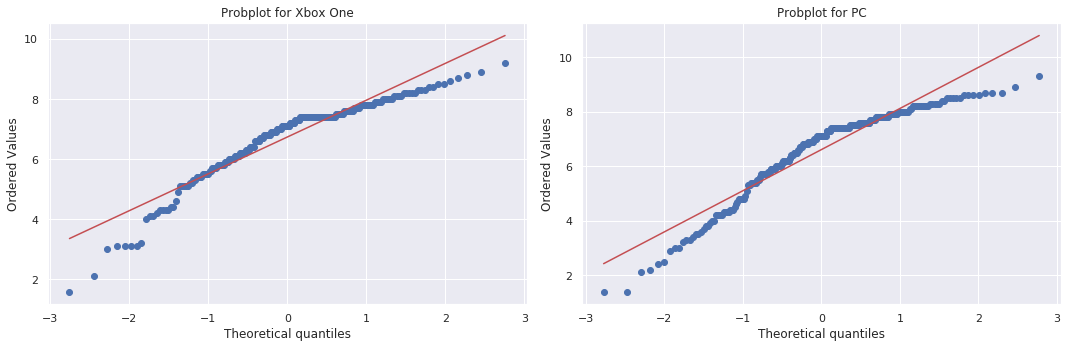

In [93]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
st.probplot(xone, plot=ax1)
st.probplot(pc, plot=ax2)
ax1.set_title("Probplot for Xbox One")
ax2.set_title("Probplot for PC")
fig.tight_layout()
plt.show()

Видно, что распределение стремится к нормальному. В таком случае, воспользуемся критерием Стьюдента для проверки нулевой гипотезы. Уровень значимости выберем 0.05.

In [94]:
check_null_hypothesis(xone, pc, norm=True)

p-value: 0.32948069158361093
Не удалось отклонить нулевую гипотезу


Нулевую гипотезу не удалось отклонить, соответственно гипотеза - "Средние пользовательские рейтинги платформ Xbox One и PC равны".

### Гипотеза 2 - Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем _нулевую_ гипотезу: "Средние пользовательские рейтинги жанров _Action_ и _Sports_ равны". Тест будет осуществляться как сравнение двух средних, так как сравниваем две выборки по средним.

Сформулируем _альтернативную_ гипотезу: "Средние пользовательские рейтинги жанров _Action_ и _Sports_ разные".

In [95]:
action = action_sports[action_sports.genre == 'action' ]['user_score']
sports = action_sports[action_sports.genre == 'sports' ]['user_score']
print(action.shape)
print(sports.shape)

(991,)
(249,)


In [96]:
print('Action')
print(action.apply([np.mean, np.var, np.std]))
print()
print('Sports')
print(sports.apply([np.mean, np.var, np.std]))

Action
mean    7.096872
var     1.087172
std     1.042675
Name: user_score, dtype: float64

Sports
mean    5.877510
var     3.009170
std     1.734696
Name: user_score, dtype: float64


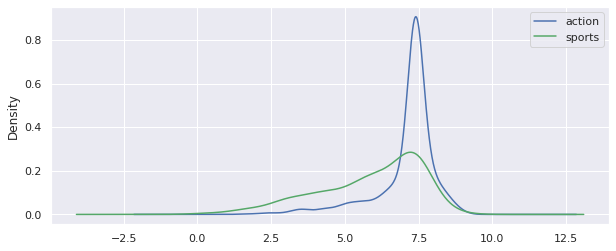

In [97]:
# посмотрим на распределение
ax = action.plot.kde(figsize=(10,4))
sports.plot.kde(ax=ax)
ax.legend(['action', 'sports'])

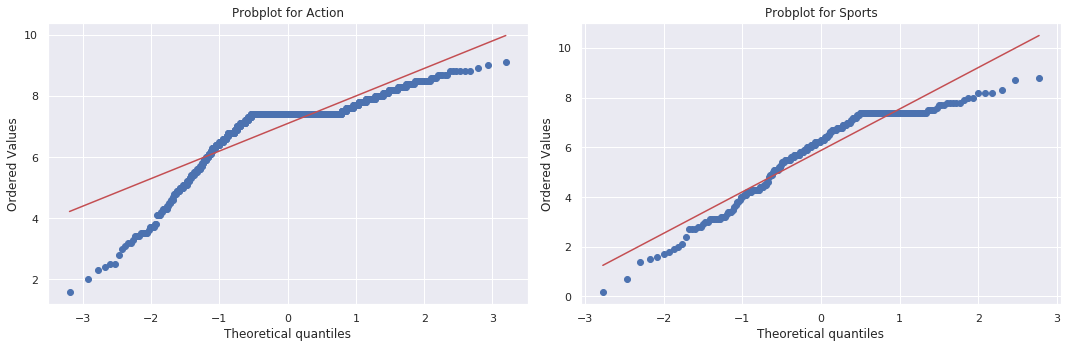

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
st.probplot(action, plot=ax1)
st.probplot(sports, plot=ax2)
ax1.set_title("Probplot for Action")
ax2.set_title("Probplot for Sports")
fig.tight_layout()
plt.show()

Видно по графику распределения, что в зоне среднего распределение похоже на нормальное, однако графику _proplot_ можно увидеть, что распределение не нормальное. Для проверки нулевой гипотезы будем использовать непераметрический критерий Манна-Уитни.

In [99]:
check_null_hypothesis(action, sports, alpha=0.05, norm=False)

p-value: 9.4272771724281e-33
Отклоняем нулевую гипотезу


Нулевую гипотезу отклонили, соответственно имеет место альтернативная гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные".

### Вывод

Проверка гипотез о равестве средних в категориях жанров и платформ по оценке пользователей показала, что жанр влияет на объем продаж, но платформа не влияет на продажи.

## Общий вывод

В ходе анализа данных об игровых платформах за определенный период времени выяснено, что
* продажи слабо зависят от оценки пользователей только для определенных игровых платформ;
* существует средняя зависимость между оценкой критиков и ростом продаж;
* топ-5 хорошо окупаемых жанров - _action, sports, shooter, role-paying, misc_ , самый окупаемый жанр - _action_ ;
* для разных регионов отличаются передпочтения по жанрам и выбору игровой платформы, регион JP - самый индвивуальный;
* продажи в разных регионах практически не зависят от рейтинга организации _ESRB_ ;
* жанр игры влияет на объем продаж;
* игровая платформа не влияет на объем продаж.
